# Dense And Sparse Correspondence
In this tutorial we show how DINOv3 features can be used to establish correspondences between two objects.

## Bluewhite Logic

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import sys
from pathlib import Path

dinov3_repo_path = Path("/home/nati/source/dinov3")
sys.path.extend(["/home/nati/source/ml-common/src"])

import os

os.chdir(dinov3_repo_path)

In [2]:
import pickle
import os
import urllib

import numpy as np
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm

from bw_ml_common.datasets.data_accessor_factory import create_dataset_accessor
from dino_bw.dino_classifier_inference import regress_dino_embeddings, visualize_results
from dino_bw.dino_embeddings_utils import get_class_idx_from_name, load_dinov3_model, resize_transform, setup_patch_quantization_filter
from dino_bw.bw_defs import MODEL_TO_NUM_LAYERS, IMAGENET_MEAN, IMAGENET_STD

In [3]:
dino_patch_size = 16
dino_image_size = 768
dataset_path = Path("/home/nati/source/datasets/bw2508")
model_name = "dinov3_vits16"
checkpoint_path = Path("/home/nati/source/dinov3/checkpoints/dinov3_vits16_pretrain.pth")

In [4]:
model = load_dinov3_model(dinov3_location=dinov3_repo_path, model_name=model_name, checkpoint_path=checkpoint_path)

INFO: using base=100 for rope new
INFO: using min_period=None for rope new
INFO: using max_period=None for rope new
INFO: using normalize_coords=separate for rope new
INFO: using shift_coords=None for rope new
INFO: using rescale_coords=2 for rope new
INFO: using jitter_coords=None for rope new
INFO: using dtype=fp32 for rope new
INFO: using mlp layer as FFN


Loading DINOv3 model: dinov3_vits16
Model loaded successfully


In [5]:
image_left_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/dense_sparse_matching/image_left.jpg"
mask_left_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/dense_sparse_matching/image_left_fg.png"
image_right_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/dense_sparse_matching/image_right.jpg"
mask_right_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/dense_sparse_matching/image_right_fg.png"

def load_image_from_url(url: str) -> Image:
    with urllib.request.urlopen(url) as f:
        return Image.open(f)


image_left = load_image_from_url(image_left_uri)
mask_left = load_image_from_url(mask_left_uri)

image_right = load_image_from_url(image_right_uri)
mask_right = load_image_from_url(mask_right_uri)

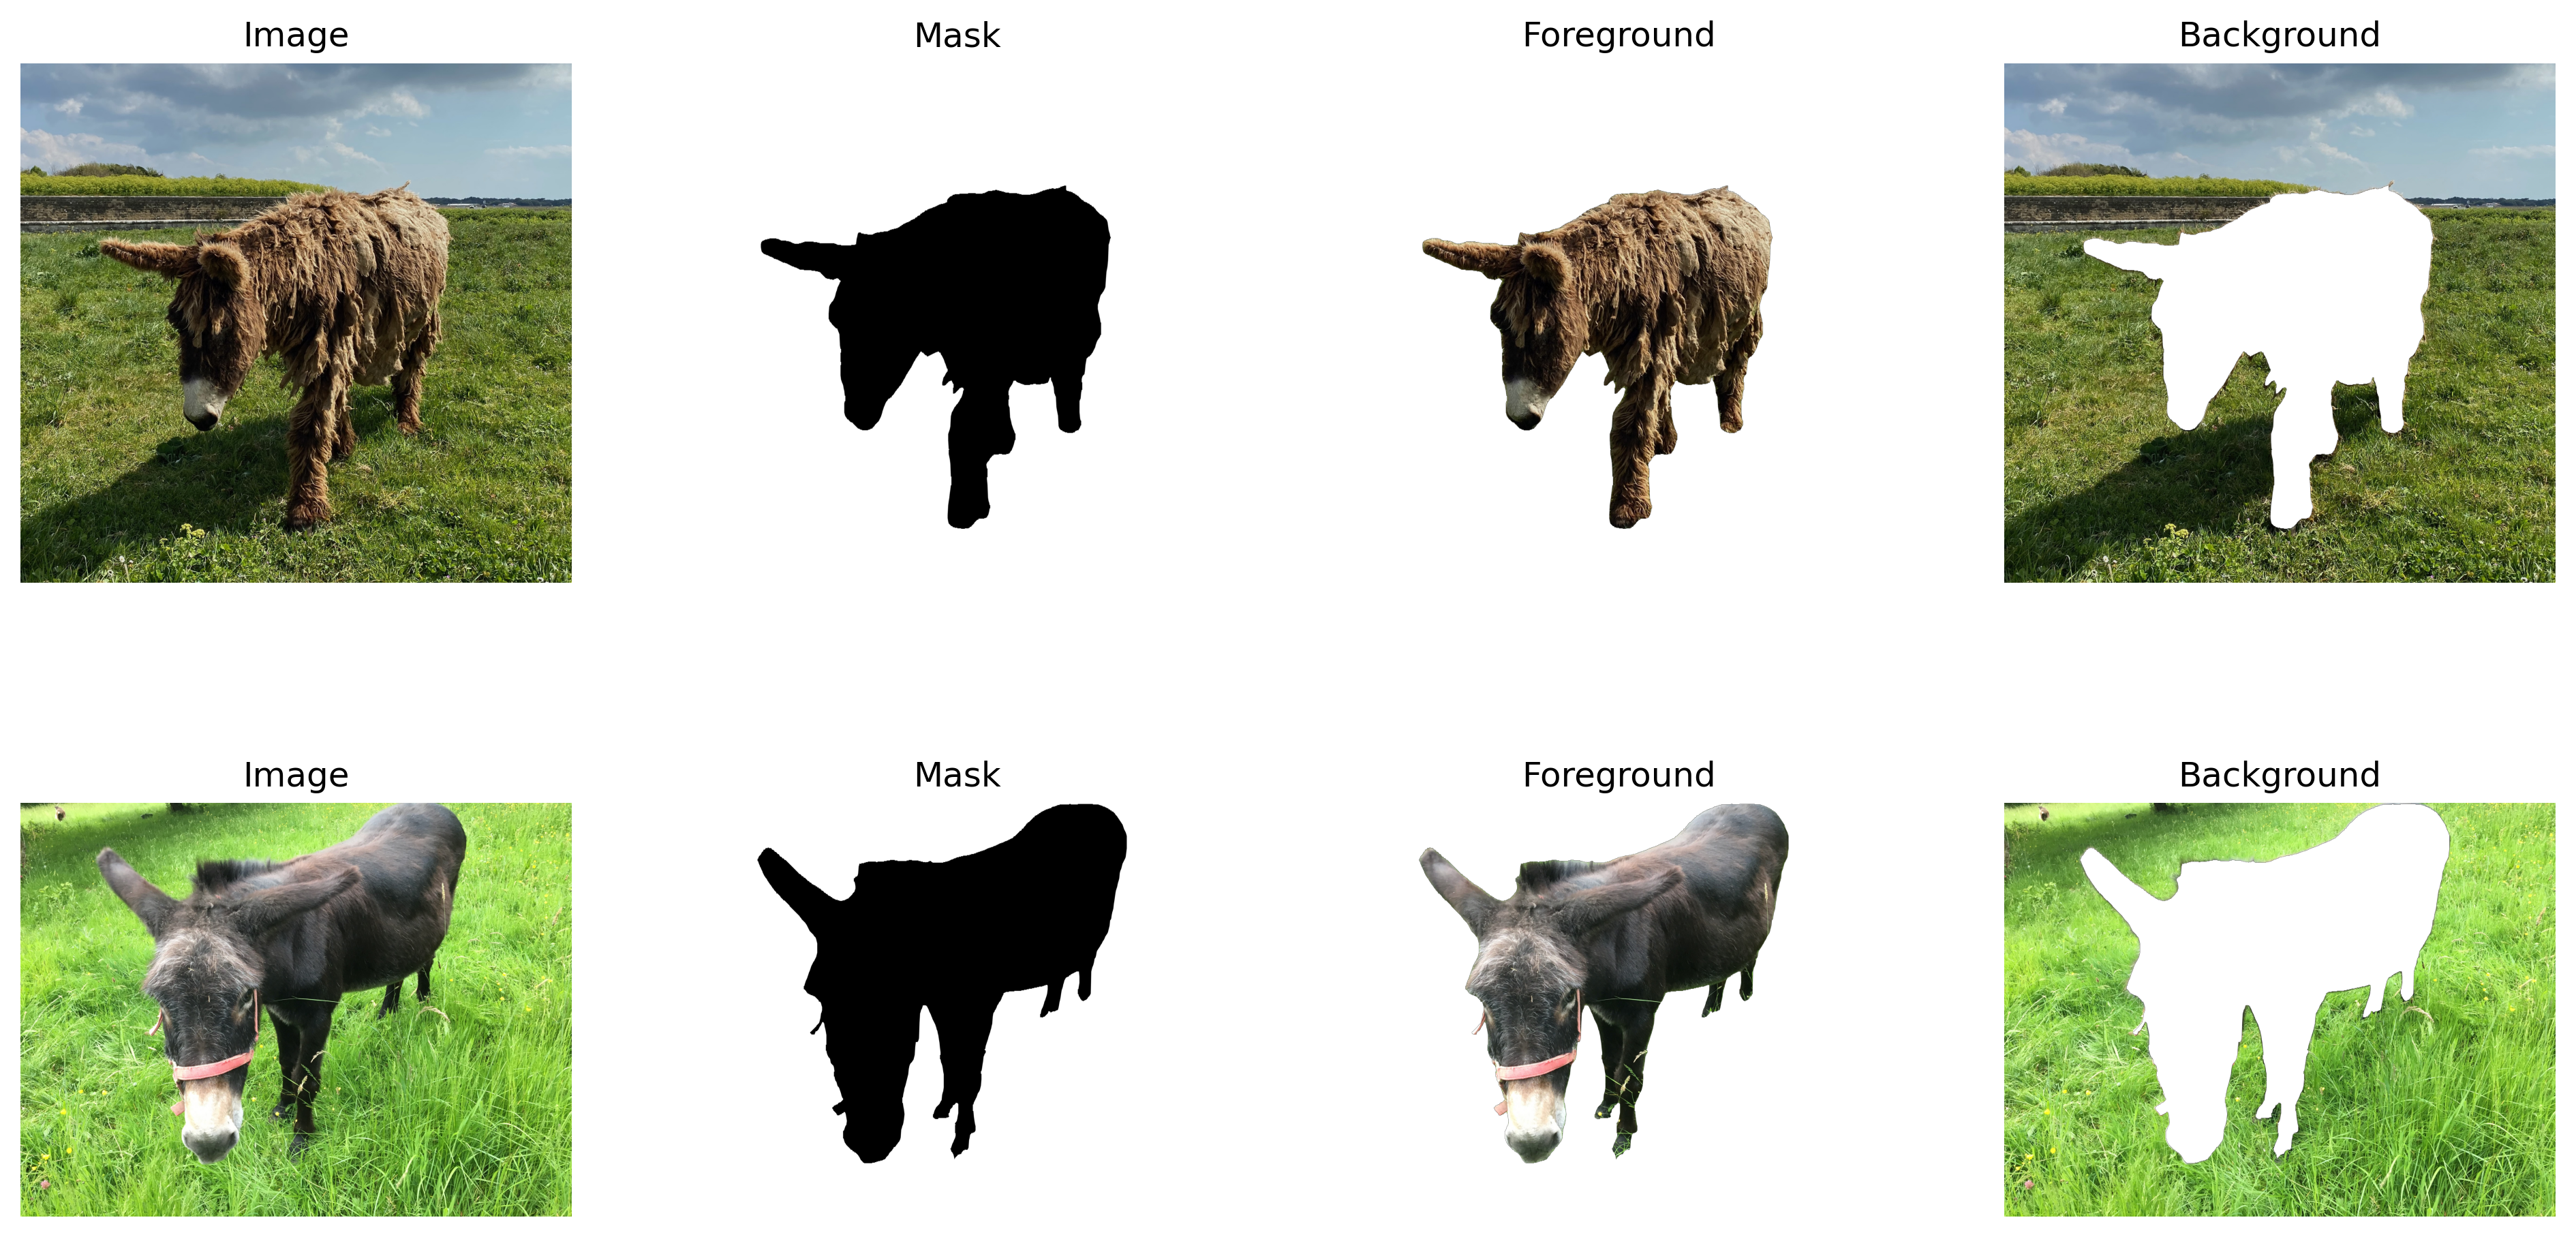

In [6]:
plt.figure(figsize=(16, 8), dpi=300)

for j, (image, mask) in enumerate([(image_left, mask_left), (image_right, mask_right)]):
    foreground = Image.composite(image, mask, mask)
    mask_bg_np = np.copy(np.array(mask))
    mask_bg_np[:, :, 3] = 255 - mask_bg_np[:, :, 3]
    mask_bg = Image.fromarray(mask_bg_np)
    background = Image.composite(image, mask_bg, mask_bg)

    data_to_show = [image, mask, foreground, background]
    data_labels = ["Image", "Mask", "Foreground", "Background"]


    for i in range(len(data_to_show)):
        plt.subplot(2, len(data_to_show), 4 * j + i + 1)
        plt.imshow(data_to_show[i])
        plt.axis('off')
        plt.title(data_labels[i], fontsize=12)
        


In [8]:
patch_quant_filter = setup_patch_quantization_filter(patch_size=dino_patch_size)
n_layers = MODEL_TO_NUM_LAYERS[model_name]
patch_mask_values = []
patch_features = []

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for image, mask in tqdm([(image_left, mask_left), (image_right, mask_right)], desc="Processing images"):
            # processing mask
            mask = mask.split()[-1]
            mask_resized = resize_transform(mask, image_size=dino_image_size, patch_size=dino_patch_size)
            #mask_quantized = patch_quant_filter(mask_resized).squeeze().view(-1).detach().cpu()
            mask_quantized = patch_quant_filter(mask_resized).squeeze().detach().cpu()
            patch_mask_values.append(mask_quantized)
            # processing image
            image = image.convert('RGB')
            image_resized = resize_transform(image, image_size=dino_image_size, patch_size=dino_patch_size)
            image_resized = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_resized = image_resized.unsqueeze(0).cuda()

            feats = model.get_intermediate_layers(image_resized, n=range(n_layers), reshape=True, norm=True)
            dim = feats[-1].shape[1]
            #patch_features.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())
            patch_features.append(feats[-1].squeeze().detach().cpu())


Processing images:   0%|          | 0/2 [00:00<?, ?it/s]

Processing images: 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]


In [12]:
MASK_FG_THRESHOLD = 0.5

patch_features[0] = F.normalize(patch_features[0], p=2, dim=0)
patch_features[1] = F.normalize(patch_features[1], p=2, dim=0)

heatmaps = torch.einsum(
    "k f, f h w -> k h w",
    patch_features[0].view(dim, -1).permute(1, 0),
    patch_features[1],
)

# compute 2D patch locations in the left image
n_patches_left = patch_features[0].shape[1] * patch_features[0].shape[2]
patch_indices_left = torch.arange(n_patches_left)
locs_2d_left = (
    torch.stack(
        (
            patch_indices_left // patch_features[0].shape[2],  # row
            patch_indices_left % patch_features[0].shape[2]    # column
        ),
        dim=-1
    ) + 0.5
) * dino_patch_size

# compute the corresponding 2D patch locations in the right image
patch_indices_right = torch.flatten(heatmaps, start_dim=-2).argmax(dim=-1)
locs_2d_right = (
    torch.stack(
        (
            patch_indices_right // patch_features[1].shape[2],  # row
            patch_indices_right % patch_features[1].shape[2]    # column
        ),
        dim=-1
    ) + 0.5
) * dino_patch_size

# foreground patches mask in the left image
patches_left_fg_selection = (patch_mask_values[0].view(-1) > MASK_FG_THRESHOLD)
# left image patches mask for patches that map to a foreground patch in the right image
patches_right_fg_selection = (patch_mask_values[1].view(-1)[patch_indices_right] > MASK_FG_THRESHOLD)
# select foreground left image patches that map to foreground right image patches
patches_fg_selection = (patches_left_fg_selection * patches_right_fg_selection)

# select (row, col) coordinates for the matched patches
locs_2d_left_fg = locs_2d_left[patches_fg_selection, :]
locs_2d_right_fg = locs_2d_right[patches_fg_selection, :]

### Matching Patches

For each patch within the foreground object in the left image, we search for the closest patch in the right image using [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between patch features. We select correspondences only for foreground objects.

### Dense Correspondence
We now show dense correspondences between patches using the color space estimated through PCA over foreground patches in the left image. Closer colors correspond to more similar patches.

In [13]:
pca = PCA(n_components=3, whiten=True)
fg_patches_left = patch_features[0].view(dim, -1).permute(1, 0)[patches_fg_selection]
pca.fit(fg_patches_left)

PCA(n_components=3, whiten=True)

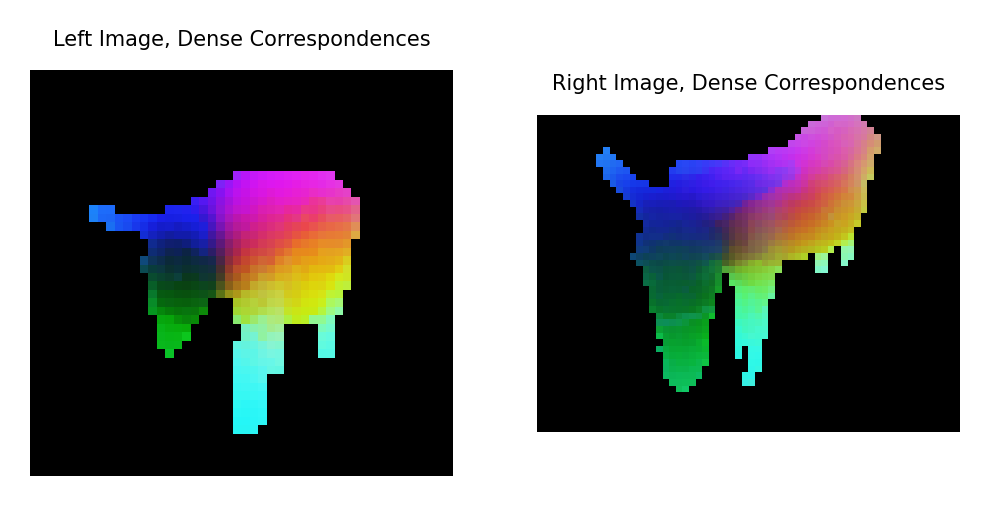

In [15]:
# get colors for the left image
h_patches_left = patch_features[0].shape[1]
w_patches_left = patch_features[0].shape[2]
x_left = patch_features[0].view(dim, -1).permute(1, 0)

projected_image_left = torch.from_numpy(
    pca.transform(x_left.numpy())
).view(h_patches_left, w_patches_left, 3)
# multiply by 2.0 and pass through a sigmoid to get vibrant colors 
projected_image_left = torch.nn.functional.sigmoid(projected_image_left.mul(2.0)).permute(2, 0, 1)

# get colors for the right image
h_patches_right = patch_features[1].shape[1]
w_patches_right = patch_features[1].shape[2]
x_right = patch_features[1].view(dim, -1).permute(1, 0)
projected_image_right = torch.from_numpy(
    pca.transform(x_right.numpy())
).view(h_patches_right, w_patches_right, 3)
projected_image_right = torch.nn.functional.sigmoid(projected_image_right.mul(2.0)).permute(2, 0, 1)

# apply foreground masks to both visualizations
projected_image_left *= (patch_mask_values[0] > MASK_FG_THRESHOLD)[None, :, :]
projected_image_right *= (patch_mask_values[1] > MASK_FG_THRESHOLD)[None, :, :]

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(projected_image_left.permute(1, 2, 0))
plt.title("Left Image, Dense Correspondences", fontsize=5)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(projected_image_right.permute(1, 2, 0))
plt.title("Right Image, Dense Correspondences", fontsize=5)
plt.axis('off')
plt.show()

### Sparse Correspondence

Finally, we show the established correspondences via the sparse set of matched points.

Non-stratified points: (471, 2)
Stratified points: (54, 2)


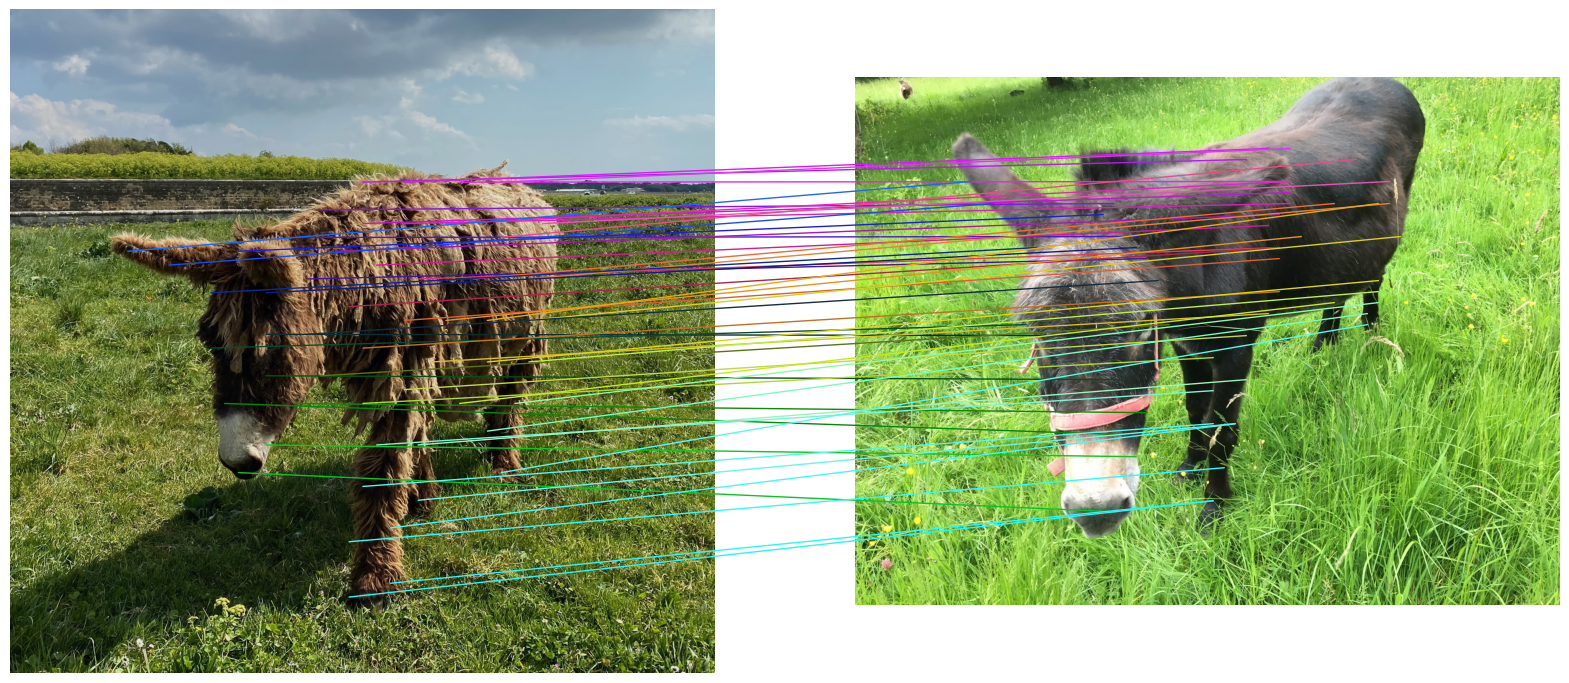

In [45]:
# image scale to go from patches to the original image coordinates
scale_left = image_left.height / dino_image_size
scale_right = image_right.height / dino_image_size


STRATIFY_DISTANCE_THRESHOLD = 100.0

def compute_distances_l2(X, Y, X_squared_norm, Y_squared_norm):
    distances = -2 * X @ Y.T
    distances.add_(X_squared_norm[:, None]).add_(Y_squared_norm[None, :])
    return distances


def stratify_points(pts_2d: torch.Tensor, threshold: float = 100.0) -> torch.Tensor:
    # pts_2d: [N, 2]
    n = len(pts_2d)
    max_value = threshold + 1
    pts_2d_sq_norms = torch.linalg.vector_norm(pts_2d, dim=1)
    pts_2d_sq_norms.square_()
    distances = compute_distances_l2(pts_2d, pts_2d, pts_2d_sq_norms, pts_2d_sq_norms)
    distances.fill_diagonal_(max_value)
    distances_mask = torch.empty((n, n), dtype=pts_2d.dtype, device=pts_2d.device)
    torch.le(distances, threshold, out=distances_mask)
    ones_vec = torch.ones(n, device=pts_2d.device, dtype=pts_2d.dtype)
    counts_vec = torch.mv(distances_mask, ones_vec)
    indices_mask = np.ones(n)
    while torch.any(counts_vec).item():
        index_max = torch.argmax(counts_vec).item()
        indices_mask[index_max] = 0
        distances[index_max, :] = max_value
        distances[:, index_max] = max_value
        torch.le(distances, threshold, out=distances_mask)
        torch.mv(distances_mask, ones_vec, out=counts_vec)
    indices_to_exclude = np.nonzero(indices_mask == 0)[0]
    indices_to_keep = np.nonzero(indices_mask > 0)[0]
    return indices_to_exclude, indices_to_keep

print(f"Non-stratified points: {tuple(locs_2d_left_fg.shape)}")

indices_to_exclude, indices_to_keep = stratify_points(locs_2d_left_fg * scale_left, STRATIFY_DISTANCE_THRESHOLD**2)

sparse_points_left_yx = locs_2d_left_fg[indices_to_keep, :].cpu().numpy()
sparse_points_right_yx = locs_2d_right_fg[indices_to_keep, :].cpu().numpy()

print(f"Stratified points: {sparse_points_left_yx.shape}")

# show original left and right images
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.imshow(image_left)
ax1.set_axis_off()
ax2 = fig.add_subplot(122)
ax2.imshow(image_right)
ax2.set_axis_off()


for i, (row_left, col_left), (row_right, col_right) in zip(
    indices_to_keep, sparse_points_left_yx, sparse_points_right_yx
):
    row_left_orig, col_left_orig = locs_2d_left_fg[i]
    # use the color used for PCA visualization
    color = projected_image_left[
        :,
        int(row_left_orig / dino_patch_size),
        int(col_left_orig / dino_patch_size)
    ].cpu().numpy()
    con = ConnectionPatch(
        xyA=(col_left * scale_left, row_left * scale_left),
        xyB=(col_right * scale_right, row_right * scale_right),
        coordsA="data",
        coordsB="data",
        axesA=ax1,
        axesB=ax2,
        color=color,
    )
    ax2.add_artist(con)